In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

In [99]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

In [101]:
train.columns

Index(['id', 'Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars',
       'Garage Area', 'Kitchen Qual', 'Total Bsmt SF', '1st Flr SF',
       'Bsmt Qual', 'Full Bath', 'Year Built', 'Year Remod/Add',
       'Garage Yr Blt', 'target'],
      dtype='object')

In [102]:
numerical = train.columns[train.dtypes != 'object']
#학습에 필요한 피쳐들을 따로 정의 합니다.
numeric_features = numerical[1:-1]
numeric_features

Index(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Year Built',
       'Year Remod/Add', 'Garage Yr Blt'],
      dtype='object')

In [103]:
def plot_features(df, name, features, outlier_dict = None, is_outlier = False):
  plt.figure(figsize=(20,15))
  plt.suptitle(name,fontsize = 30, y = 1)
  target = train['target']
  for i in range(len(features)):
    plt.subplot(4,3,i+1)
    plt.xlabel(features[i])
    plt.ylabel('target')
    plt.plot(df[features[i]], target, linestyle = 'none', marker = 'o')
    if is_outlier:
      outlier = outlier_dict[features[i]]
      plt.plot(df[features[i]].iloc[outlier], target[outlier], linestyle='none', marker='o',c='r',label='outlier')

    plt.tight_layout() #레이아웃을 바로 잡아준다.


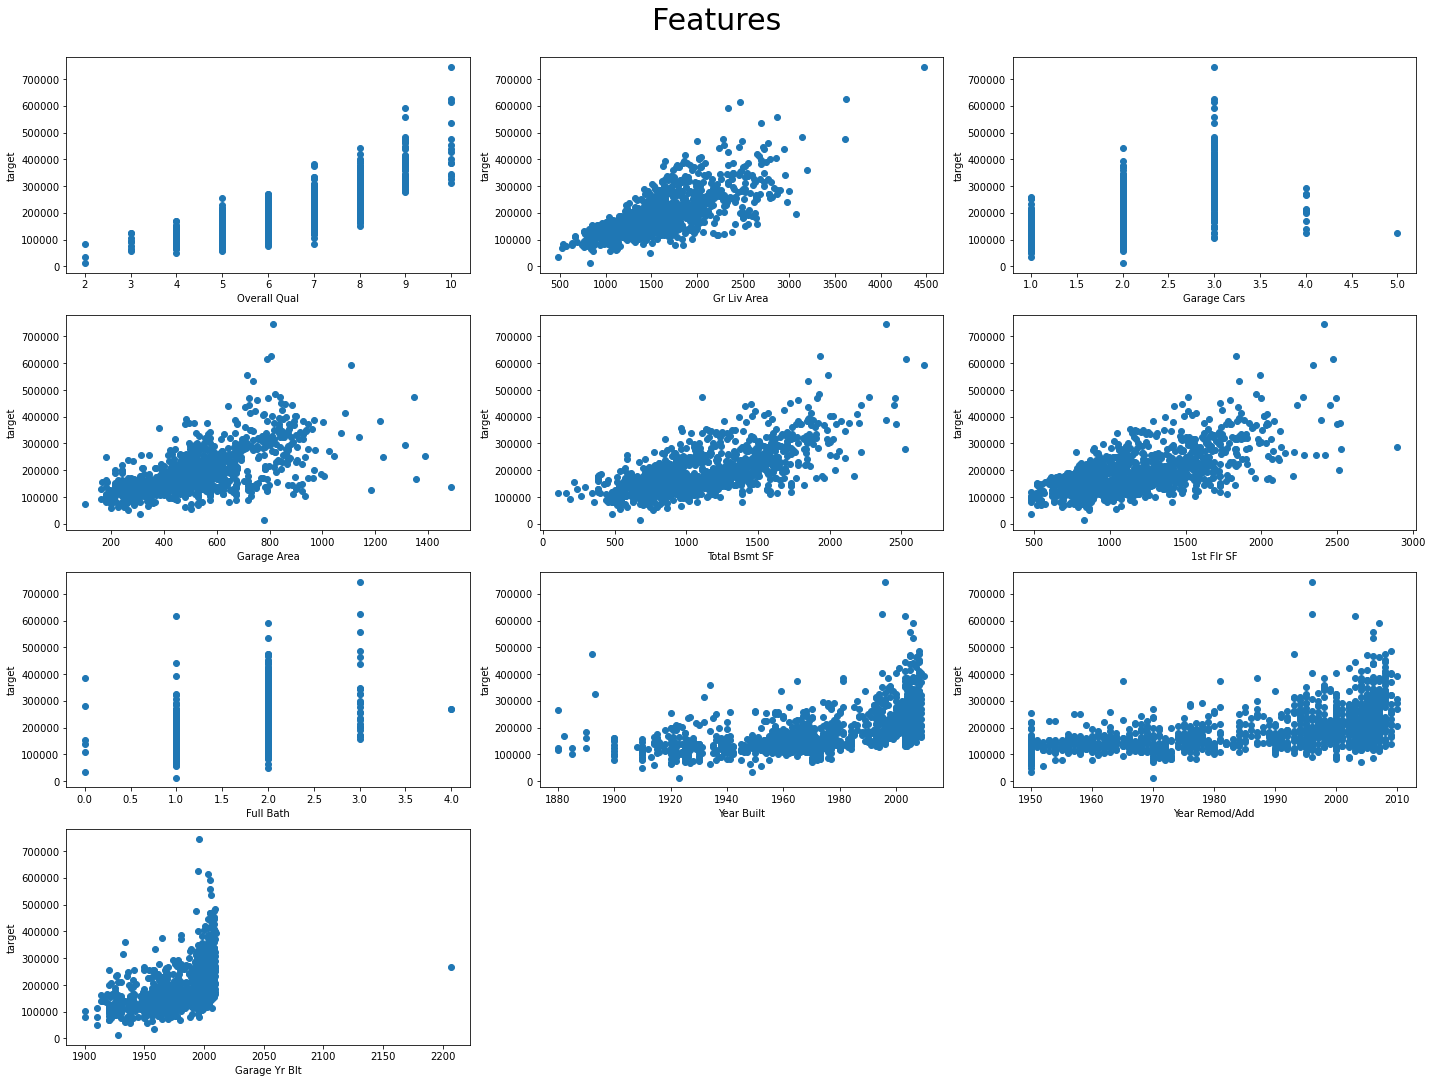

In [104]:
plot_features(train,'Features',numeric_features)

In [107]:
from collections import defaultdict
quantile_25 = train.loc[::,numeric_features].apply(lambda x: np.quantile(x, 0.25))
quantile_75 = train.loc[::,numeric_features].apply(lambda x: np.quantile(x, 0.75))
iqr = quantile_75 - quantile_25
lower = quantile_25 - iqr * 1.5
upper = quantile_75 + iqr * 1.5
out_indexes = np.where((train[numeric_features] <= lower) | (train[numeric_features] >= upper))
outlier_dict = defaultdict(list)
for r,c in (zip(*out_indexes)):
    outlier_dict[numeric_features[c]].append(r)

* IQR을 활용해 이상치를 제거해 줍니다.

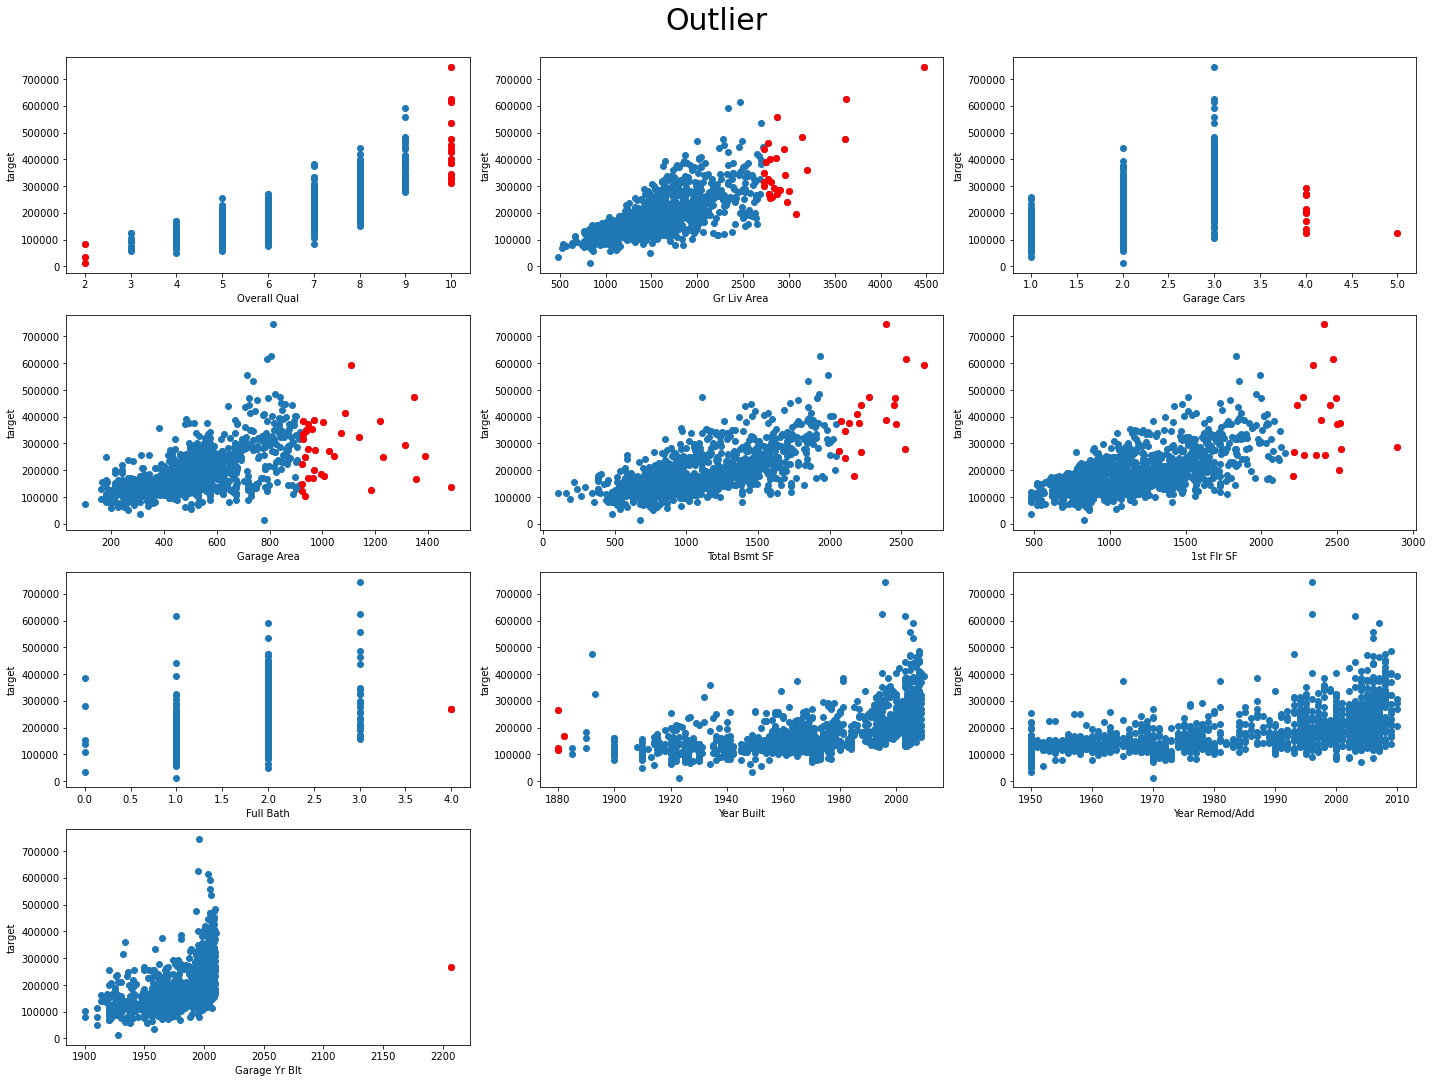

In [110]:
plot_features(train,"Outlier", numeric_features, outlier_dict, is_outlier=True)

#### IQR은 유용한 데이터를 손실할 수 있습니다. 
* 예를 들어 Over Qual 같은 경우 명확한 패턴이 보임에도 불구하고 데이터의 크기로 인해 많은 데이터가 이상치로 취급됩니다. 
* 명확한 이상치를 제거하기 위해 추세에서도 어긋나고 논리적으로 설명되지 않는 데이터들만을 제거해줍니다.  

In [112]:
#remove outlier
#remove Garage Yr Blt, Full bath
for i in ['Garage Yr Blt','Full Bath']:
    train.iloc[outlier_dict[i]] = None
#결측치가 삭제 된 것을 확인 할 수 있다.
before = len(train)
train.dropna(inplace=True)
print(f"remove cnt: {before - len(train)}")

remove cnt: 3


Text(0.5, 1.0, 'correlation between features')

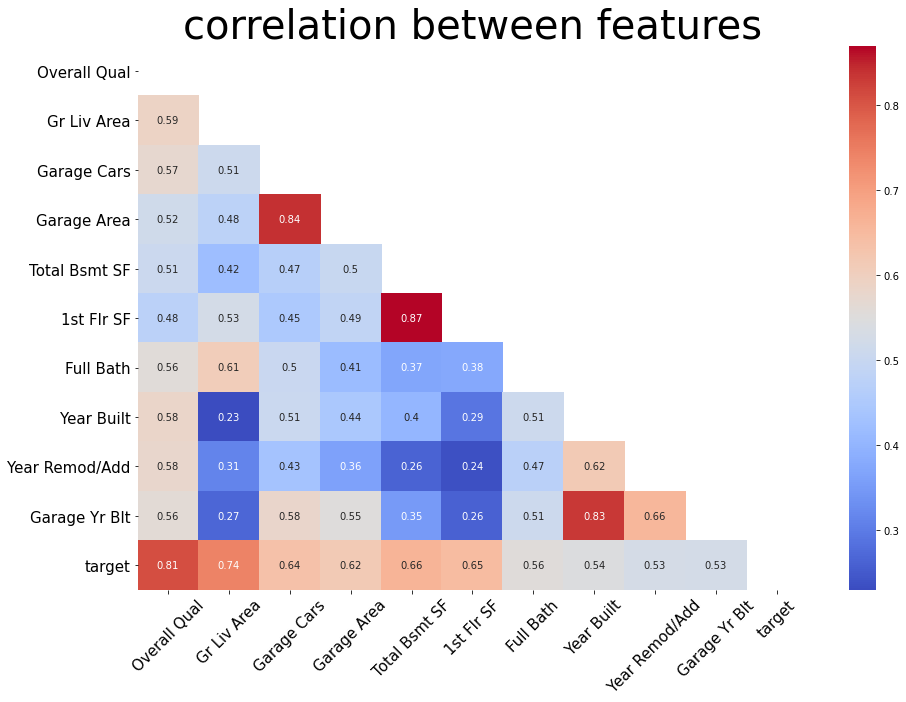

In [113]:
plt.figure(figsize=(15,10))
heat_table = train[numerical[1:]].corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, mask = mask, cmap='coolwarm')
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)

(Garage Area, Garage Cars), (Year Built, Garage Yr Blt),(1st Flr SF, Total Bsmt SF)은 높은 상관 관계를 갖으므로 과적합의 위험이 존재하므로 중복되는 속성들을 제거해줍니다. 그전에 앞서 카테고리형 데이터 또한 활용하기 위해 라벨 인코딩 작업을 진행합니다.


In [91]:
#파이프라인에 활용할 라벨 인코딩 클래스를 생성합니다.
from sklearn.base import BaseEstimator, TransformerMixin
class CategoricalTransformer(BaseEstimator,TransformerMixin):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
        return
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = [c for c in X.columns[X.dtypes == 'object']]
        for c in features:
            X[c] = X[c].apply(lambda x: ['Po','TA','Fa','Gd','Ex'].index(x))
        return X

In [125]:
total_features = train.columns[1:-1] #id,target을 제거해준 모든 피쳐
valid_features =  total_features.drop(['Garage Cars','Garage Yr Blt','1st Flr SF'])
cat = CategoricalTransformer(train)
X_train, X_eval, y_train, y_eval = train_test_split(cat.transform(train)[total_features],train['target'], train_size = 0.7, test_size = 0.3, random_state = 4)

* Garage Area 보단 이산형 자료형인 Garage Cars를 삭제합니다.
* Base SF가 1st Flr SF보다 강건한 패턴을 보이므로 1st를 삭제합니다.
* Grage Year의 경우 2200년이라는 이상치가 있고 target과의 상관성도 좀 더 낮으므로 Garage Year을 제거합니다.

In [131]:
#모델을 생성하고 파이프라인을 구축합니다.
regulator = Ridge(alpha=1,solver="cholesky",
                random_state=42)

model = Pipeline([
    ("label_encoder",CategoricalTransformer(train)),
    ("poly_features",PolynomialFeatures(degree=3, include_bias=True)),
    ("std_scaler",StandardScaler()),
    ("regul_reg",regulator)
                ])
                
def fit_model(X,y):
    model.fit(X, y)
    pred = model.predict(X)
    return pred

In [133]:
def visualize(pred, y, name):
    plt.figure(figsize = (12,8))
    plt.plot(range(len(y)), pred, label = 'pred',linestyle='none',marker='o')
    plt.plot(range(len(y)), y ,label = 'target',linestyle='none',marker='o')
    mse = np.mean((y - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.1f}')
    plt.legend()

시각화를 통해 피쳐를 제거하는 것과 아닌 것중 어떤 것이 적합한지 확인해 봅니다.

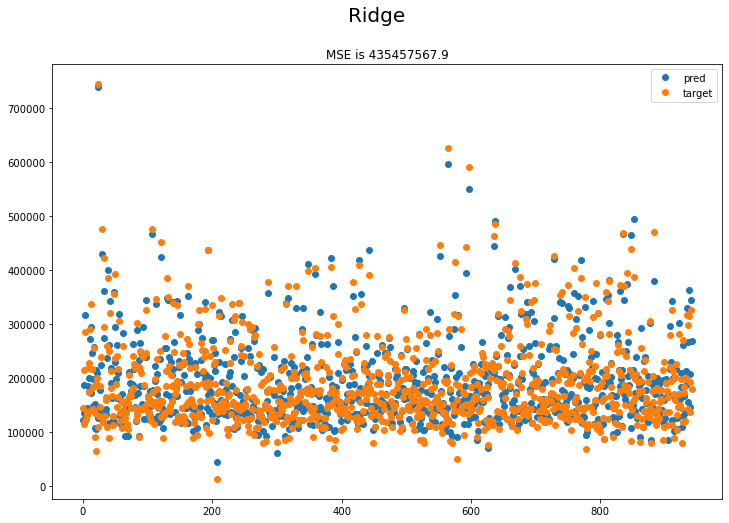

In [134]:
visualize(fit_model(X_train, y_train), y_train, 'Ridge')

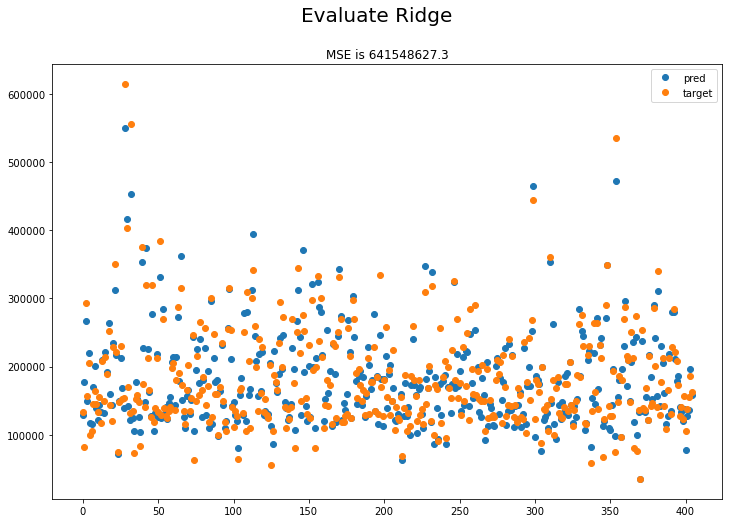

In [135]:
visualize(model.predict(X_eval), y_eval, 'Evaluate Ridge')

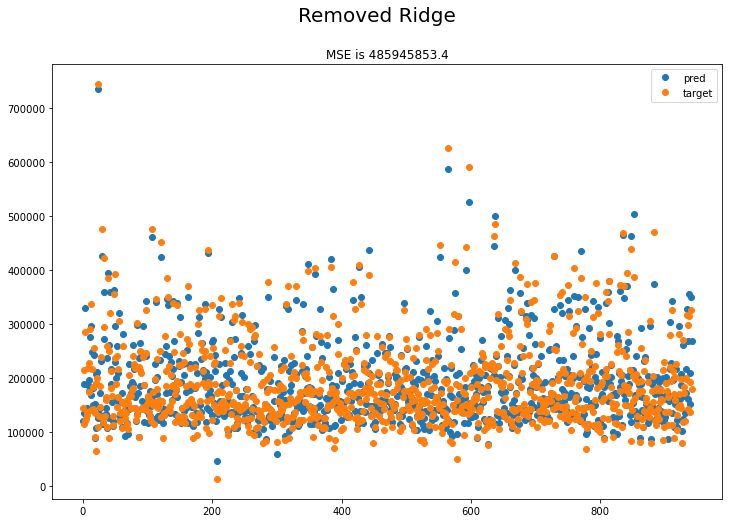

In [136]:
visualize(fit_model(X_train[valid_features], y_train), y_train, 'Removed Ridge')

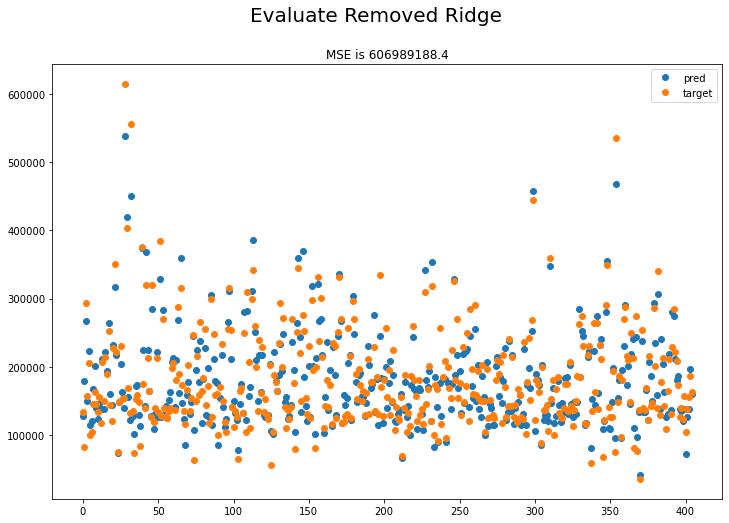

In [137]:
visualize(model.predict(X_eval[valid_features]), y_eval, 'Evaluate Removed Ridge')

그래프를 보면 피쳐를 제거하지 않은 경우가 학습 셋에서 MSE 값은 더욱 우수합니다. 하지만 이는 과적합의 결과입니다. evaluation 셋의 결과를 보면 피쳐를 제거한 데이터 셋이 더욱 우수한 성능을 보입니다. 이에 따라 과적합 방지를 위해 피처를 제거한 데이터 셋을 이용해 모델을 학습시킵니다.

피쳐가 제거된 데이터로 피팅된 릿지 모델의 정규화 파라미터를 튜닝해줍니다. 

In [138]:
for i in [1000,300,100,30,10,1]:
  regulator = Ridge(alpha=i,solver="cholesky",
                  random_state=42)
  model.set_params(regul_reg__alpha=i)
  model.fit(X_train[valid_features], y_train)
  pred = model.predict(X_eval[valid_features])
  mse = ((y_eval - pred) ** 2).mean()
  print(f'mse: {mse}, alpha: {i}')

mse: 665643405.26665, alpha: 1000
mse: 632613389.4668441, alpha: 300
mse: 615167896.0046383, alpha: 100
mse: 606780363.0042564, alpha: 30
mse: 604052930.8682989, alpha: 10
mse: 606989188.4117938, alpha: 1


In [141]:
#10의 경우 성능이 가장 좋았으므로 파라미터를 10으로 설정해줍니다.
model.set_params(regul_reg__alpha=10)
model.fit(X_train[valid_features],y_train)

Pipeline(steps=[('label_encoder',
                 CategoricalTransformer(X=          id  Overall Qual  Gr Liv Area  Exter Qual  Garage Cars  Garage Area  \
0        1.0          10.0       2392.0           4          3.0        968.0   
1        2.0           7.0       1352.0           3          2.0        466.0   
2        3.0           5.0        900.0           1          1.0        288.0   
3        4.0           5.0       1174.0           1          2.0        576.0   
4        5.0           7.0       1958.0           3          3.0        936.0   
...      ...           ...          ...         ...          ...          ...   
1345  1346.0           6.0       1756.0           3          2.0        422.0   
1346  1347.0           9.0       2748.0           3          3.0        850.0   
1347  1348.0           5.0       1214.0           1          1.0        318.0   
1348  1349.0           5.0        894.0           1          2.0        440...
4         2005.0          2005.0   

In [142]:
test_X = cat.transform(test)
sample_submission = pd.DataFrame({'id':test['id'], 'target':model.predict(test_X[valid_features])})
sample_submission.to_csv('sample.csv',index=None)
